Presented by: Reza Saadatyar <br/>
E-mail: Reza.Saadatyar92@gmail.com

**Importing the required Libraries**

In [29]:
import numpy as np
# import pandas as pd
import seaborn as sns
from scipy import stats
from scipy import signal
from tensorflow import keras
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from matplotlib.colors import ListedColormap
from sklearn import datasets, preprocessing, model_selection, multiclass, linear_model, neural_network, svm, tree, naive_bayes, neighbors, ensemble, discriminant_analysis, metrics

# from Plot_decision_regions import plot_decision_regions

**Functions**

In [80]:
# =============================================== Preparing data =========================================================
def preparing_data(data, labels):
    
    if data.shape[0] < data.shape[1]:
        data = data.T
    
    if len(y.shape) > 1:
        labels = np.max(labels) + 1  # Assuming classes are 0-indexed
    
    mod = preprocessing.LabelEncoder()
    labels = mod.fit_transform(labels)
    
    return data, labels
 
# ==================================================== Filtering =========================================================
def filtering(data, f_low, f_high, order, fs, filter_type="low"):
    if data.ndim > 1:
        if data.shape[0] > data.shape[1]:
            data = data.T
            
    f_low = f_low / (fs / 2)
    f_high = f_high / (fs / 2)
    
    if filter_type == "low":
        b, a = signal.butter(order, f_low, btype='low')
    elif filter_type == "high":
        b, a = signal.butter(order, f_high, btype='high')
    elif filter_type == "bandpass":
        b, a = signal.butter(order, [f_low, f_high], btype='bandpass')
    elif filter_type == "bandstop":
        b, a = signal.butter(order, [f_low, f_high], btype='bandstop')
    filtered_data = signal.filtfilt(b, a, data)
    
    return filtered_data.T

# ================================================= Plot data ============================================================
def plot_data(filtered_data, fs=None, first_point=0, last_point=100, val_ylim='', size_fig=(7,5), title='', display_figure="off"):
    
    if display_figure == "on":
        if filtered_data.shape[0] < filtered_data.shape[1]:
            filtered_data = filtered_data.T
            
        filtered_data = filtered_data[first_point:last_point,:]
        
        std = np.sort(np.std(filtered_data, axis=0))
        if len(std) > 100:
            std = np.mean(std[1:len(std)-1])
        else:
            std = np.mean(std)
        
        _, axs = plt.subplots(nrows=1, sharey='row', figsize=size_fig)
        offset = np.arange(filtered_data.shape[1]*std*val_ylim, 1, -std*val_ylim)
      
        if fs is not None and np.array(fs) > 0:
            time = (np.linspace(start=first_point/fs, stop=last_point/fs, num=len(filtered_data))).flatten()
            line = axs.plot(time, filtered_data + offset, linewidth=1)
            axs.set_xlabel('Time (sec)', fontsize=10)
        else:
            line = axs.plot(filtered_data + offset, linewidth=1)
            axs.set_xlabel('sample', fontsize=10)
        
        axs.set_title(title, fontsize=10)
        axs.set_yticks(offset)
        axs.set_yticklabels(["ch" + str(i) for i in range(1, filtered_data.shape[1] + 1)],  weight='bold')
        axs.tick_params(axis='x', labelsize=9)
        axs.tick_params(axis='y', labelsize=8)
        axs.set_ylabel('Channels', fontsize=10)
        axs.tick_params(axis='y', color='k', labelcolor='k')
        axs.grid(False)
        ytick_labels = plt.gca().get_yticklabels()
        for i, label in enumerate(ytick_labels):
            # line[i].set_color(line[i].get_color())
            label.set_color(line[i].get_color())
            
        axs.autoscale(enable=True, axis="x",tight=True)
        min = np.min(np.min(filtered_data + offset, axis=0))
        max = np.max(np.max(filtered_data + offset, axis=0))
        axs.set_ylim(min + min*0.02, max + max*0.01)

# ============================================== Data normalization ======================================================                          
def data_normalization(x_train, x_test, method=1):
    if x_train.ndim == 1:
        x_train = x_train.reshape(-1, 1)
        x_test = x_test.reshape(-1, 1)
        
    if method == 1:
        norm = preprocessing.MinMaxScaler()
    elif method == 2:
        norm = preprocessing.StandardScaler()
        
    x_train = norm.fit_transform(x_train)
    x_test = norm.transform(x_test)
    
    return x_train, x_test

# ================================================ Plot features =========================================================   
def plot_features(data, labels, fig_size=(4, 3), title="Data raw"):
   
   if data.shape[0] < data.shape[1]: 
       data = data.T
       
   lab = np.unique(labels)
   colors = np.array(sns.color_palette("bright", len(lab)))
   
   if data.shape[0] < data.shape[1]: 
       data =data.T
       
   if data.shape[1] < 3:
       fig = plt.figure(figsize=fig_size)

   if data.shape[1] == 1:
      
      grid = plt.GridSpec(4, 4, hspace=0.06, wspace=0.06)
      ax = fig.add_subplot(grid[1:, :3])
      ax1 = fig.add_subplot(grid[0, :3], yticklabels=[], sharex=ax)
      
      for i in range(0, len(lab)):
         
         tim = np.linspace(np.min(data[labels==lab[i], 0]), np.max(data[labels==lab[i], 0]), num=len(data[labels==lab[i], 0]), retstep=True)
         ax.plot(tim[0], data[labels==lab[i], 0], '.', markersize=10, color=colors[i, :], label=lab[i])
         
         _, bins = np.histogram(data[labels==lab[i], 0], density=True)
         ax1.plot(bins, stats.norm.pdf(bins, np.mean(data[labels==lab[i], 0]), np.std(data[labels==lab[i], 0])), linewidth=1.5, color=colors[i, :])
         ax1.fill_between(bins, y1=stats.norm.pdf(bins, np.mean(data[labels==lab[i], 0]), np.std(data[labels==lab[i], 0])), y2=0, alpha=0.4)
         
      ax.set_xlabel('Feature 1', fontsize=10, va='center')
      ax.tick_params(axis='x', length=1.5, width=1, which='both', bottom=True, top=False, labelbottom=True, labeltop=False, pad=0)
      ax.tick_params(axis='y', length=1.5, width=1, which="both", bottom=False, top=False, labelbottom=True, labeltop=True, pad=0)
     
   elif data.shape[1] < 3:
       
       grid = plt.GridSpec(4, 4, hspace=0.06, wspace=0.06)
       ax = fig.add_subplot(grid[1:, :3])
       ax1 = fig.add_subplot(grid[0, :3], yticklabels=[], sharex=ax)
       ax2 = fig.add_subplot(grid[1:, 3], xticklabels=[], sharey=ax)
       
       for i in range(0, len(lab)):
           
           ax.plot(data[labels==lab[i], 0], data[labels==lab[i], 1], '.', markersize=10, color=colors[i, :], label=lab[i])
           
           _, bins = np.histogram(data[labels==lab[i], 0], density=True)
           ax1.plot(bins, stats.norm.pdf(bins, np.mean(data[labels==lab[i], 0]), np.std(data[labels==lab[i], 0])), linewidth=1.5, color=colors[i, :])
           ax1.fill_between(bins, y1=stats.norm.pdf(bins, np.mean(data[labels==lab[i], 0]), np.std(data[labels==lab[i], 0])), y2=0, alpha=0.4)
           
           _, bins = np.histogram(data[labels==lab[i], 1], density=True)
           ax2.plot(stats.norm.pdf(bins, np.mean(data[labels==lab[i], 1]), np.std(data[labels==lab[i], 1])), bins, linewidth=2.5, color=colors[i, :])
           ax2.fill_betweenx(bins, stats.norm.pdf(bins, np.mean(data[labels==lab[i], 1]), np.std(data[labels==lab[i], 1])), 0, alpha=0.4, color=colors[i, :])
        
       ax2.spines[['top', 'right', 'bottom']].set_visible(False), 
       ax2.tick_params(bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
       ax.set_xlabel('Feature 1', fontsize=10, va='center'), ax.set_ylabel('Feature 2', fontsize=10, labelpad=-1, rotation=90, va='center')
       ax.tick_params(axis='x', length=1.5, width=1, which='both', bottom=True, top=False, labelbottom=True, labeltop=False, pad=0)
       ax.tick_params(axis='y', length=1.5, width=1, which="both", bottom=False, top=False, labelbottom=True, labeltop=True, pad=0)
           
   elif data.shape[1] > 2:
      fig = plt.figure(figsize=[4, 3])
      ax = fig.add_axes((0.02, -0.05, 0.9, 0.9), projection="3d")
      ax1 = fig.add_axes((0.22, 0.67, 0.52, 0.16))
      ax2 = fig.add_axes((0.8, 0.18, 0.13, 0.47))
      ax3 = fig.add_axes((-0.05, 0.18, 0.13, 0.47))
      
      for i in range(0, len(lab)):
         
         ax.plot3D(data[labels==lab[i], 0], data[labels==lab[i], 1], data[labels==lab[i], 2], '.', markersize=10, color=colors[i, :], label=lab[i])
         
         _, bins = np.histogram(data[labels==lab[i], 0], density=True)
         ax1.plot(bins, stats.norm.pdf(bins, np.mean(data[labels==lab[i], 0]), np.std(data[labels==lab[i], 0])), linewidth=2.5, color=colors[i, :])
         ax1.fill_between(bins, y1=stats.norm.pdf(bins, np.mean(data[labels==lab[i], 0]), np.std(data[labels==lab[i], 0])), y2=0, alpha=0.4, color=colors[i, :])
         
         _, bins = np.histogram(data[labels==lab[i], 1], density=True)
         ax2.plot(stats.norm.pdf(bins, np.mean(data[labels==lab[i], 1]), np.std(data[labels==lab[i], 1])), bins, linewidth=2.5, color=colors[i, :])
         ax2.fill_betweenx(bins, stats.norm.pdf(bins, np.mean(data[labels==lab[i], 1]), np.std(data[labels==lab[i], 1])), 0, alpha=0.4, color=colors[i, :])
         
         _, bins = np.histogram(data[labels==lab[i], 2], density=True)
         ax3.plot(-stats.norm.pdf(bins, np.mean(data[labels==lab[i], 2]), np.std(data[labels==lab[i], 2])), bins, linewidth=2.5, color=colors[i, :])
         ax3.fill_betweenx(bins, 0, -stats.norm.pdf(bins, np.mean(data[labels==lab[i], 2]), np.std(data[labels==lab[i], 2])), alpha=0.4, color=colors[i, :])
      
      ax.view_init(5, -120)
      ax.set_xlabel('Feature 1', labelpad=-1, fontsize=10, va='center'), ax.set_ylabel('Feature 2', fontsize=10, labelpad=1, rotation=90, va='center')
      ax.set_zlabel('Feature 3', labelpad=-8, fontsize=10, va='center')
      ax.tick_params(axis='x', length=1.5, width=1, which='both', bottom=True, top=False, labelbottom=True, labeltop=False, pad=-6, rotation=-90)
      ax.tick_params(axis='y', length=1.5, width=1, which="both", bottom=False, top=False, labelbottom=True, labeltop=True, pad=-6, rotation=90)
      ax.tick_params(axis='z', which='both', bottom=False, top=False, labelbottom=True, labeltop=False, pad=-2)
      
      ax2.spines[['top', 'right', 'bottom']].set_visible(False), ax3.spines[['top', 'bottom', 'left']].set_visible(False)
      ax2.tick_params(bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
      ax3.tick_params(bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)

   ax.grid(visible="on")
   ax1.set_title(title, fontsize=10, pad=0, y=1)
   ax1.spines[['top', 'left', 'right']].set_visible(False),    
   ax1.tick_params(bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
#    ax1.legend(title='Class', loc="best", ncol=3, handlelength=0.3, handletextpad=0.2, fontsize=9)  # bbox_to_anchor=(0.1, pos1.x1-0.02, pos1.x1-0.02, 0)
   ax.legend(title='Class', loc=5, ncol=3, handlelength=0.15, handletextpad=0.25, fontsize=9) 
   
   fig.subplots_adjust(wspace=0, hspace=0), plt.autoscale(enable=True, axis="x",tight=True)
   # ax.yaxis.set_ticks(np.linspace(ax.get_yticks()[1], ax.get_yticks()[-2], int(len(ax.get_yticks()) / 2), dtype='int'))
   # ax.tick_params(direction='in', colors='grey', grid_color='r', grid_alpha=0.5)

# ================================================ Plot_classification ===================================================  
def plot_classification(data_train, label_train, data_test, label_test, model, type_class, position_title=0.05, fig_size=(3,3)):
    
    if data_train.shape[0] < data_train.shape[1]:
        data_train = data_train.T
    
    if data_test.shape[0] < data_test.shape[1]:
        data_test = data_test.T   
    
    miss_class_train = label_train - model.predict(data_train)      # predict the train labels
    miss_class_train = len(miss_class_train[miss_class_train != 0])
    
    miss_class_test = label_test - model.predict(data_test)      # predict the test labels
    miss_class_test = len(miss_class_test[miss_class_test != 0]) 
    
    if data_train.shape[1] < 3:
        
        fig, axs = plt.subplots(1, 2, sharey='row', figsize=fig_size)
        
        resolution = 0.03
        lab = np.unique(label_train)

        x_combined = np.vstack((data_train, data_test))
        y_combined = np.hstack((label_train, label_test))
        x1_min, x1_max = x_combined[:, 0].min() - 1, x_combined[:, 0].max() + 1
        x2_min, x2_max = x_combined[:, 1].min() - 1, x_combined[:, 1].max() + 1
        xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
        z = model.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
        # --------------------------------------------------- Result Plot ---------------------------------------------------
        colors = list(reversed(sns.color_palette("bright", len(lab)).as_hex()))
        cmp = ListedColormap(colors[:len(lab)])
        
        axs[0].contourf(xx1, xx2, z.reshape(xx1.shape), alpha=0.2, cmap=cmp)
        axs[0].set_xlim(xx1.min(), xx1.max())
        axs[0].set_ylim(xx2.min(), xx2.max())

        axs[1].contourf(xx1, xx2, z.reshape(xx1.shape), alpha=0.2, cmap=cmp)
        axs[1].set_xlim(xx1.min(), xx1.max())
        axs[1].set_ylim(xx2.min(), xx2.max())

        for i in range(0, len(np.unique(y_combined))):
            axs[0].plot(data_train[label_train==lab[i], 0], data_train[label_train==lab[i], 1], '.', color=colors[i], label=lab[i], markersize=10)
            axs[1].plot(data_test[label_test==lab[i], 0], data_test[label_test==lab[i], 1], '.', color=colors[i], label=lab[i], markersize=10)
        
        axs[0].tick_params(axis='x', length=1.5, width=1, which='both', bottom=True, top=False, labelbottom=True, labeltop=False, pad=0.5)
        axs[0].tick_params(axis='y', length=1.5, width=1, which="both", bottom=False, top=False, labelbottom=True, labeltop=True, pad=0.5)
        axs[1].tick_params(axis='x', length=1.5, width=1, which='both', bottom=True, top=False, labelbottom=True, labeltop=False, pad=0.5)
        axs[1].tick_params(axis='y', length=1.5, width=1, which="both", bottom=False, top=False, labelbottom=True, labeltop=True, pad=0.5)
        
        axs[0].set_xlabel('Feature 1',  fontsize=10, va='center'), axs[0].set_ylabel('Feature 2', labelpad=-1, fontsize=10, va='center')
        axs[0].set_title(f"Traing; Miss_classes: {miss_class_train}#", loc='left', pad=0, fontsize=10) 
        axs[0].legend(title='Class', ncol=3, handlelength=-0.1, handletextpad=0.3)
        
        axs[1].set_xlabel('Feature 1',  fontsize=10, va='center'), axs[1].set_title(f"Test; Miss_classes: {miss_class_test}#", loc='right', pad=0, fontsize=10)
        
        plt.subplots_adjust(top=1, bottom=0, left=0, right=1, wspace=0.05, hspace=0), 
        fig.suptitle(type_class, fontsize=11,x=0.51,  y=1+position_title, fontweight='normal', color='black', va='top')
        
    elif data_train.shape[1] > 2:
        
        x_train = data_train[:, 0:3]
        x_test = data_test[:, 0:3]
        lab = np.unique(label_train)
        
        fig = plt.figure(figsize=(7, 3))
        ax1 = fig.add_subplot(121, projection='3d')
        ax2 = fig.add_subplot(122, projection='3d')

        for i in range(0, len(lab)):
            ax1.plot3D(x_train[label_train==lab[i], 0], x_train[label_train==lab[i], 1], x_train[label_train==lab[i], 2], '.', label=lab[i])
            ax2.plot3D(x_test[label_test==lab[i], 0], x_test[label_test==lab[i], 1], x_test[label_test==lab[i], 2], '.')

        ax1.view_init(5, -120), ax2.view_init(5, -120) 
        ax1.set_xlabel('Feature 1', labelpad=-1, fontsize=10, va='center'), ax2.set_xlabel('Feature 1', labelpad=-1, fontsize=10, va='center')
        ax1.set_ylabel('Feature 2', labelpad=1, fontsize=10, va='center'), ax2.set_ylabel('Feature 2', labelpad=1, fontsize=10, va='center')
        ax1.set_zlabel('Feature 3', labelpad=-8, fontsize=10, va='center', rotation=45)  
        
        ax1.tick_params(axis='x', length=1.5, width=1, which='both', bottom=True, top=False, labelbottom=True, labeltop=False, pad=-4)
        ax2.tick_params(axis='x', length=1.5, width=1, which='both', bottom=True, top=False, labelbottom=True, labeltop=False, pad=-4)
        ax1.tick_params(axis='y', length=2, width=1, which="both", bottom=True, top=False, labelbottom=True, labeltop=True, pad=-6, rotation=90)
        ax2.tick_params(axis='y', length=2, width=1, which="both", bottom=True, top=False, labelbottom=True, labeltop=True, pad=-6, rotation=90)
        ax1.tick_params(axis='z', length=2, width=1, which='both', bottom=False, top=False, labelbottom=True, labeltop=False, pad=-2)
        ax2.tick_params(axis='z', length=2, width=1, which='both', bottom=False, top=False, labelbottom=True, labeltop=False, pad=-2)
        
        ax1.legend(title='Class', loc=5, ncol=3, handlelength=0, handletextpad=0.2, fontsize=9)  # bbox_to_anchor=(0.1, pos1.x1-0.02, pos1.x1-0.02, 0)
        ax1.set_title(f"Traing; Miss_classes: {miss_class_train }#", loc='right', pad=0, y=0.8, fontsize=10)
        ax2.set_title(f"Test; Miss_classes: {miss_class_test}#", loc='right', pad=0, y=0.8, fontsize=10),
        fig.suptitle(type_class, fontsize=11, x=0.51,  y=0.95, fontweight='normal', color='black', va='top')
            
        plt.tight_layout(w_pad=-1, h_pad=0), plt.subplots_adjust(top=1, bottom=0, left=0 ,wspace=-0.2, hspace=0), plt.autoscale(enable=True, axis="x", tight=True)
    
    plt.autoscale(enable=True, axis="x", tight=True),             
    # ax.tick_params(direction='in', length=6, width=2, colors='grey', grid_color='r', grid_alpha=0.5)
    
# =================================================== KNN_optimal ========================================================  
def knn_optimal(data_train, label_train, data_test, label_test, n=21, fig_size=(3,2), display_figure="off"):
    if np.shape(data_train)[0] < np.shape(data_train)[1]:  # Convert Data training & Test >>>> m*n; m > n
        data_train = data_train.T
        data_test = data_test.T
    t = np.arange(1, n)
    accuracy_train = np.zeros(n-1)
    accuracy_test = np.zeros(n-1)
    for i in range(1 , n):
        model = neighbors.KNeighborsClassifier(metric='minkowski', n_neighbors=i)
        model.fit(data_train, label_train)
        accuracy_train[i-1] = model.score(data_train, label_train)
        accuracy_test[i-1] = model.score(data_test, label_test)
    
    if display_figure == "on":
        
        plt.figure(figsize=fig_size)
        plt.plot(t, accuracy_train, label="Training")
        plt.plot(t, accuracy_test, label="Test")
        plt.xticks(t)
        plt.legend(fontsize=8)
        
        plt.xlabel("Number of neighbors")
        plt.ylabel("Accuracy")
        plt.title("KNN", fontsize=10)
        plt.tick_params(axis='x', rotation=90)

    return t[np.argmax(accuracy_test)]

**1. Load data**

In [165]:
method = 1
if method==1:
   x, y = datasets.make_classification(n_samples=1000,      # Number of samples in the dataset
                                       n_features=5,       # Number of total features
                                       n_informative=4,    # Number of informative features
                                       n_redundant=0,      # Number of redundant features
                                       n_classes=3,        # Number of classes in the dataset (binary classification in this case)
                                       random_state=1)     # Seed for reproducibility)
   # print(f"{x.shape=},\n{x=},\n{y=}")
elif method==2:
   iris = datasets.load_iris()
   x = iris.data
   y = iris.target
   # print(f"{iris.data.shape=},\n{iris.feature_names=},\n{iris.target_names=},\n{iris.data=},\n{iris.target}")

**2. Preparing the data**

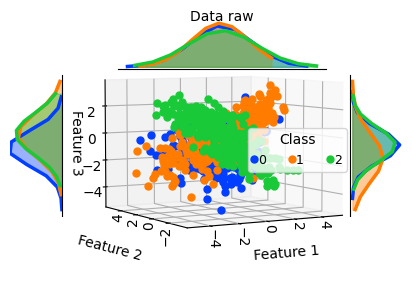

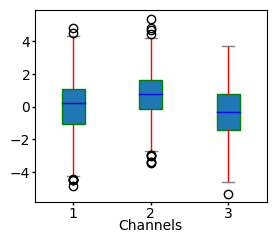

In [166]:
data, labels = preparing_data(x, y)
data=data[:,0:3]
plot_features(data, labels, fig_size=(4, 3), title="Data raw");
# ------------------------------------------------------ Boxplot -------------------------------------------------------------
plt.figure(figsize=(3, 2.5))
plt.boxplot(data, boxprops=dict(color='green'), whiskerprops=dict(color='red'), medianprops=dict(color='blue'), capprops=dict(color='gray'), patch_artist=True)
plt.xlabel('Channels', fontsize=10, va='center'),
plt.tick_params(axis='x', length=2, width=1, which='both', bottom=True, top=False, labelbottom=True, labeltop=False, pad=1)
plt.tick_params(axis='y', length=2, width=1, which='both', bottom=True, top=False, labelbottom=True, labeltop=False, pad=1)

**3. Filtering**<br/>

`Fs > f_high > f_low`

In [108]:
filtered_data = filtering(data, f_low=3, f_high=10, order=3, fs=50, filter_type="low")    # btype:'low','high','bandpass','bandstop'
plot_data(filtered_data, fs=None, first_point=0, last_point=500, val_ylim=3, size_fig=(7,5), title='filtered_data', display_figure="off")

**4. Split data**

In [167]:
# data = data[:,:2]
data_train, data_test, label_train, label_test = model_selection.train_test_split(data, labels, test_size=0.3, random_state=42)

**5. Data normalization**

In [30]:
data_train, data_test = data_normalization(data_train, data_test, method=2)   # method 1: MinMaxScaler, method 2: StandardScaler

**6. Classification**<br/>

The advantages of support vector machines are:
- Effective in high dimensional spaces.
- Still effective in cases where number of dimensions is greater than the number of samples.
- Uses a subset of training points in the decision function (called support vectors), so it is also memory efficient.
- Versatile: different Kernel functions can be specified for the decision function. Common kernels are provided, but it is also possible to specify custom kernels.

Decision Tree:
- def error(p):<br/>
    return 1 - np.max([p, 1 - p])
- def gini(p):<br/>
    return (p)*(1 - (p)) + (1 - p)*(1 - (1-p))
- def entropy(p):<br/>
    return - p*np.log2(p) - (1 - p)*np.log2((1 - p))

- [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
   - penalty ---> l1, l2, elasticnet, None, default=l2; elasticnet: both L1 and L2 penalty terms are added.
   - multi_class ---> auto, ovr, multinomial, default=auto
   - solver ---> lbfgs, liblinear, newton-cg, newton-cholesky, sag, saga, default=lbfgs
   - Supported penalties by solver: lbfgs-->[l2, None]; liblinear-->[l1, l2]; newton-cg-->[l2, None]; newton-cholesky-->[l2, None]; sag-->[l2, None]; saga-->[elasticnet, l1, l2, None]
   - sag and saga fast convergence is only guaranteed on features with approximately the same scale.
   - For small datasets, liblinear is a good choice, whereas sag and saga are faster for large ones; For multiclass problems, only newton-cg, sag, saga and lbfgs handle multinomial loss;
- [Gaussian Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)
- [k-Nearest Neighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

LR_train: 0.5257142857142857, LR_test: 0.54


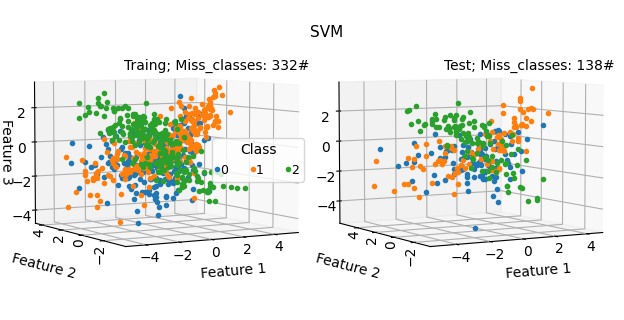

In [168]:
type_class = "SVM"
k_fold = 5
# ------------------------------------------------ Logistic Regression ----------------------------------------------------
"""
# penalty ---> l1, l2, elasticnet, None, default=l2; elasticnet: both L1 and L2 penalty terms are added.
# multi_class ---> auto, ovr, multinomial, default=auto
# solver ---> lbfgs, liblinear, newton-cg, newton-cholesky, sag, saga, default=lbfgs
# Supported penalties by solver: lbfgs-->[l2, None]; liblinear-->[l1, l2]; newton-cg-->[l2, None]; newton-cholesky-->[l2, None]; sag-->[l2, None]; saga-->[elasticnet, l1, l2, None]
# Note: sag and saga fast convergence is only guaranteed on features with approximately the same scale.
# For small datasets, liblinear is a good choice, whereas sag and saga are faster for large ones;
# For multiclass problems, only newton-cg, sag, saga and lbfgs handle multinomial loss;
"""
model = linear_model.LogisticRegression(C=1, max_iter=1000,solver='lbfgs', penalty='l2', multi_class="multinomial", verbose=0)
model.fit(data_train, label_train)
label_predict_train = model.predict(data_train) 
label_predict_test = model.predict(data_test)    #predict model
print(f"LR_train: {model.score(data_train, label_train)}, LR_test: {model.score(data_test, label_test)}")
# # ------------------------------------------------------- MLP -------------------------------------------------------------
# model = neural_network.MLPClassifier(hidden_layer_sizes=(8), max_iter=1000, alpha=1e-4, learning_rate='invscaling', solver='sgd',
#                                      random_state=1, learning_rate_init=0.05, verbose=False , tol=1e-4)    # {'adam', 'sgd', 'lbfgs'}
# model.fit(data_train, label_train)
# y_pred_train = model.predict(data_train) 
# y_pred_test = model.predict(data_test)    #predict model
# print(f"MLP_train: {model.score(data_train, label_train)}, MLP_test: {model.score(data_test, label_test)}")

# # ------------------------------------------------------- SVM -------------------------------------------------------------
# kernel_svm = "linear"   # poly, rbf, sigmoid, precomputed, if 'poly'---> degree=3
# # c ---> Regularization parameter

# model = svm.SVC(kernel=kernel_svm, random_state=0, C=10, gamma="auto", probability=True) 
# model.fit(data_train, label_train)
# model.support_vectors_
# model.support_      # get indices of support vectors
# model.n_support_  # get number of support vectors for each class
# y_pred_train = model.predict(data_train) 
# y_pred_test = model.predict(data_test)    #predict model
# print(f"SVM_train: {model.score(data_train, label_train)}, SVM_test: {model.score(data_test, label_test)}")

# # -------------------------------------------------------- DT -------------------------------------------------------------
# criterion_dt = "gini"                   #  gini, entropy, log_loss
# model = tree.DecisionTreeClassifier(criterion=criterion_dt, max_depth=5, random_state=0)
# model.fit(data_train, label_train)
# y_pred_train = model.predict(data_train) 
# y_pred_test = model.predict(data_test)    #predict model
# print(f"DT_train: {model.score(data_train, label_train)}, DT_test: {model.score(data_test, label_test)}")

# # -------------------------------------------------------- NB -------------------------------------------------------------
# model = naive_bayes.GaussianNB()
# model.fit(data_train, label_train)
# y_pred_train = model.predict(data_train) 
# y_pred_test = model.predict(data_test)    #predict model
# print(f"NB_train: {model.score(data_train, label_train)}, Nb_test: {model.score(data_test, label_test)}") 

# # -------------------------------------------------------- RF -------------------------------------------------------------       
# model = ensemble.RandomForestClassifier(n_estimators=500, max_depth=5, criterion=criterion_dt, random_state=0)
# model.fit(data_train, label_train)
# y_pred_train = model.predict(data_train) 
# y_pred_test = model.predict(data_test)    #predict model
# print(f"RF_train: {model.score(data_train, label_train)}, RF_test: {model.score(data_test, label_test)}") 

# # ---------------------------------------------------- AdaBoost -----------------------------------------------------------  
#  # model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
# # model = ensemble.AdaBoostClassifier(base_estimator=model, n_estimators=100, random_state=0)
# model = ensemble.AdaBoostClassifier(n_estimators=500, learning_rate=0.9, random_state=0)
# model.fit(data_train, label_train)
# y_pred_train = model.predict(data_train) 
# y_pred_test = model.predict(data_test)    #predict model
# print(f"AdaBoost_train: {model.score(data_train, label_train)}, AdaBoost_test: {model.score(data_test, label_test)}") 

# # ------------------------------------------------------ XGBoost ----------------------------------------------------------  
# model = XGBClassifier(max_depth=5, n_estimators=500, learning_rate=0.08, random_state=0, objective='multi:softpr_teob')
# model.fit(data_train, label_train)
# y_pred_train = model.predict(data_train) 
# y_pred_test = model.predict(data_test)    #predict model
# print(f"XGBoost_train: {model.score(data_train, label_train)}, XGBoost_test: {model.score(data_test, label_test)}") 

# # -------------------------------------------------------- LDA ------------------------------------------------------------  
# model = discriminant_analysis.LinearDiscriminantAnalysis(n_components=len(np.unique(labels)) - 1)
# model.fit(data_train, label_train)
# y_pred_train = model.predict(data_train) 
# y_pred_test = model.predict(data_test)    #predict model
# print(f"LDA_train: {model.score(data_train, label_train)}, LDA_test: {model.score(data_test, label_test)}") 

# -------------------------------------------------------- KNN ------------------------------------------------------------ 
# # weights --> uniform, distance, default=uniform
# num_k = knn_optimal(data_train, label_train, data_test, label_test, n=21, fig_size=(4,2.5))  # Obtain optimal K
# model = neighbors.KNeighborsClassifier(n_neighbors=num_k, weights='uniform', metric='minkowski')
# model.fit(data_train, label_train)
# y_pred_train = model.predict(data_train) 
# y_pred_test = model.predict(data_test)    #predict model
# print(f"KNN_train: {model.score(data_train, label_train)}, KNN_test: {model.score(data_test, label_test)}") 
plot_classification(data_train, label_train, data_test, label_test, model, type_class, position_title=0.05, fig_size=(3,3))

In [223]:
num_classes = np.max(label_test) + 1            # Binarize the labels for each class
label_train = np.eye(num_classes)[label_train]  
label_test = np.eye(num_classes)[label_test]  

- `Micro-average ROC curve:`Micro-averaging combines all classes to create a single ROC curve by treating all true positives, false positives, and false negatives as if they belong to one class. This provides an overall performance measure for the classifier without considering differences between individual classes (Aggregates performance metrics by considering all instances (regardless of class) as if they belong to a single class).
- `Macro-Average ROC Curve:`Calculate the ROC curve for each class individually, and then average the results. Each class is given equal importance, and the macro-average ROC curve gives an overall view of how well the classifier performs across different classes. This approach is not affected by imbalances in class distribution (Averages performance metrics across different classes, treating each class equally).<br/>
If the classes are imbalanced, micro-averaging may be influenced more by the larger classes. Macro-averaging treats each class equally, which can provide a balanced evaluation across all classes.

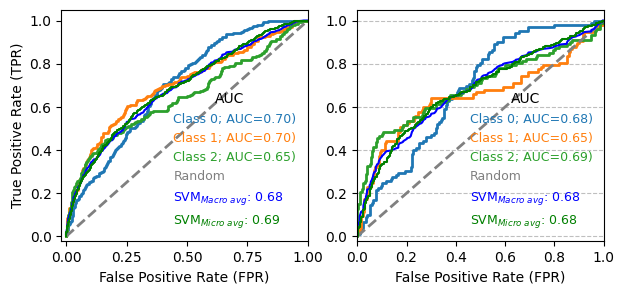

In [238]:
# ---------------------------- Initialize lists to store fpr, tpr, and roc_auc for each class ----------------------------------
fpr_tr = dict()                                
tpr_tr = dict()
roc_auc_tr = dict()
fpr_te = dict()                                
tpr_te = dict()
roc_auc_te = dict()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
# --------------------------------------------- ROC curve for each class -------------------------------------------------------
y_scores_tr = model.predict_proba(data_train)   
y_scores_te = model.predict_proba(data_test)   
  
for i in range(label_train.shape[1]):            
   fpr_tr[i], tpr_tr[i], _ = metrics.roc_curve(label_train[:, i], y_scores_tr[:, i])
   roc_auc_tr[i] = metrics.auc(fpr_tr[i], tpr_tr[i])
   axs[0].plot(fpr_tr[i], tpr_tr[i], lw=2, label=f"Class {i}; AUC={roc_auc_tr[i]:.2f})")
   
   fpr_te[i], tpr_te[i], _ = metrics.roc_curve(label_test[:, i], y_scores_te[:, i])
   roc_auc_te[i] = metrics.auc(fpr_te[i], tpr_te[i])
   axs[1].plot(fpr_te[i], tpr_te[i], lw=2, label=f"Class {i}; AUC={roc_auc_te[i]:.2f})")
# -------------------------------------- # Compute macro-average ROC curve and ROC area ----------------------------------------
all_fpr_tr = np.unique(np.concatenate([fpr_tr[i] for i in range(labels.shape[1])]))    # First aggregate all false positive rates
mean_tpr_tr = np.zeros_like(all_fpr_tr)                                                # Then interpolate all ROC curves at this points
for i in range(labels.shape[1]):
    mean_tpr_tr += np.interp(all_fpr_tr, fpr_tr[i], tpr_tr[i])
mean_tpr_tr /= labels.shape[1]       # Finally average it and compute AUC
fpr_tr[i+1] = all_fpr_tr
tpr_tr[i+1] = mean_tpr_tr
roc_auc_tr[i+1] = metrics.auc(fpr_tr[i+1], tpr_tr[i+1])

all_fpr_te = np.unique(np.concatenate([fpr_te[i] for i in range(labels.shape[1])]))    # First aggregate all false positive rates
mean_tpr_te = np.zeros_like(all_fpr_te)                                                # Then interpolate all ROC curves at this points
for i in range(labels.shape[1]):
    mean_tpr_te += np.interp(all_fpr_te, fpr_te[i], tpr_te[i])
mean_tpr_te /= labels.shape[1]       # Finally average it and compute AUC
fpr_te[i+1] = all_fpr_te
tpr_te[i+1] = mean_tpr_te
roc_auc_te[i+1] = metrics.auc(fpr_te[i+1], tpr_te[i+1])
# -------------------------------------- # Compute micro-average ROC curve and ROC area ----------------------------------------
fpr_tr[i+2], tpr_tr[i+2], _ = metrics.roc_curve(label_train.ravel(), y_scores_tr.ravel())
roc_auc_tr[i+2] = metrics.auc(fpr_tr[i+2], tpr_tr[i+2])

fpr_te[i+2], tpr_te[i+2], _ = metrics.roc_curve(label_test.ravel(), y_scores_te.ravel())
roc_auc_te[i+2] = metrics.auc(fpr_te[i+2], tpr_te[i+2])
# --------------------------------------------------------- Plot ---------------------------------------------------------------
axs[0].plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2, label='Random')
axs[0].plot(fpr_tr[i+1], tpr_tr[i+1] , color='blue', linestyle='-', lw=1.5, label=f"{type_class}$_{{Macro\ avg}}$: {roc_auc_tr[i+1]:.2f}")
axs[0].plot(fpr_tr[i+2], tpr_tr[i+2] , color='g', linestyle='-', lw=1.5, label=f"{type_class}$_{{Micro\ avg}}$: {roc_auc_tr[i+2]:.2f}")
axs[0].legend(title="AUC", loc='lower right',fontsize=9, ncol=1, frameon=False, labelcolor='linecolor', handlelength=0)
axs[0].axis(xmin=-0.02, xmax=1, ymin=-0.02, ymax=1.05)         # Set x-axis and y-axis limits in a single line
axs[0].set_xlabel('False Positive Rate (FPR)', fontsize=10), axs[0].set_ylabel('True Positive Rate (TPR)', fontsize=10)

axs[1].plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2, label='Random')
axs[1].plot(fpr_te[i+1], tpr_te[i+1] , color='blue', linestyle='-', lw=1.5, label=f"{type_class}$_{{Macro\ avg}}$: {roc_auc_te[i+1]:.2f}")
plt.plot(fpr_te[i+2], tpr_te[i+2] , color='g', linestyle='-', lw=1.5, label=f"{type_class}$_{{Micro\ avg}}$: {roc_auc_te[i+2]:.2f}")
axs[1].legend(title="AUC", loc='lower right',fontsize=9, ncol=1, frameon=False, labelcolor='linecolor', handlelength=0)
axs[1].axis(xmin=-0.02, xmax=1, ymin=-0.02, ymax=1.05)         # Set x-axis and y-axis limits in a single line
axs[1].grid(True, linestyle='--', which='major', color='grey', alpha=0.5, axis="y")
axs[1].set_xlabel('False Positive Rate (FPR)', fontsize=10)
plt.autoscale(axis="x", tight=True, enable=True)

In [192]:
roc_auc

{0: 0.6826104179045356,
 1: 0.6490274744807273,
 2: 0.6908801432907109,
 3: 0.6766490104217658,
 4: 0.6774}

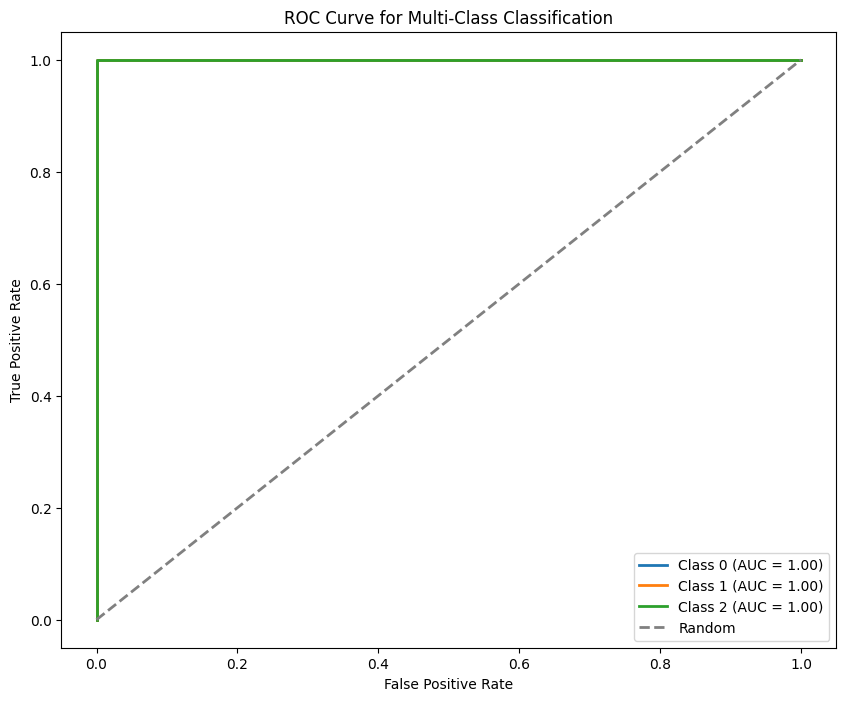

In [113]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np


# Train the classifier
classifier.fit(X_train, y_train)


y_test_bin = label_binarize(y_test, classes=np.unique(y))



# Plot the 
plt.figure(figsize=(10, 8))

for i in range(len(np.unique(y))):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')



LR_train: 0.9238095238095239, LR_test: 0.9111111111111111


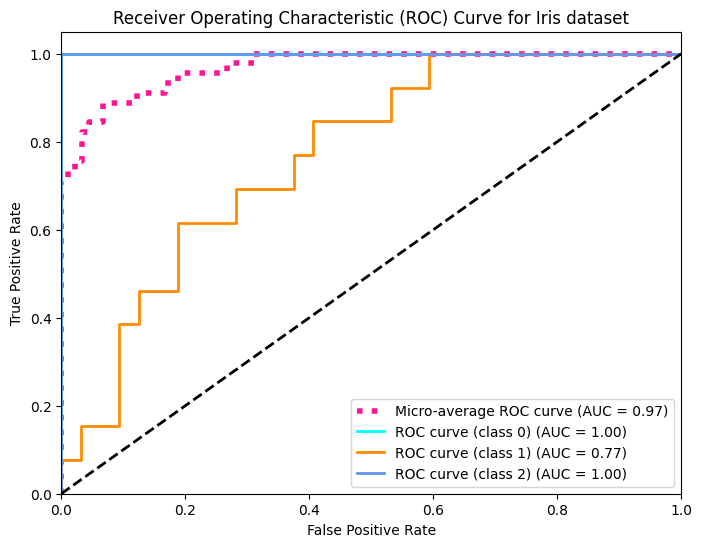

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Load iris dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Binarize the output
y_bin = label_binarize(y, classes=[0, 1, 2])
n_classes = y_bin.shape[1]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.3, random_state=42)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(LogisticRegression(max_iter=1000))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

classifier.fit(data_train, label_train)
label_predict_train = classifier.decision_function(data_train)
label_predict_test = classifier.decision_function(data_test)
# label_predict_train = model.predict(data_train) 
# label_predict_test = model.predict(data_test)    #predict model
print(f"LR_train: {classifier.score(data_train, label_train)}, LR_test: {classifier.score(data_test, label_test)}")
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure(figsize=(8, 6))

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot each class's ROC curve
colors = ['aqua', 'darkorange', 'cornflowerblue']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve (class {i}) (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Iris dataset')
plt.legend(loc='lower right')
plt.show()


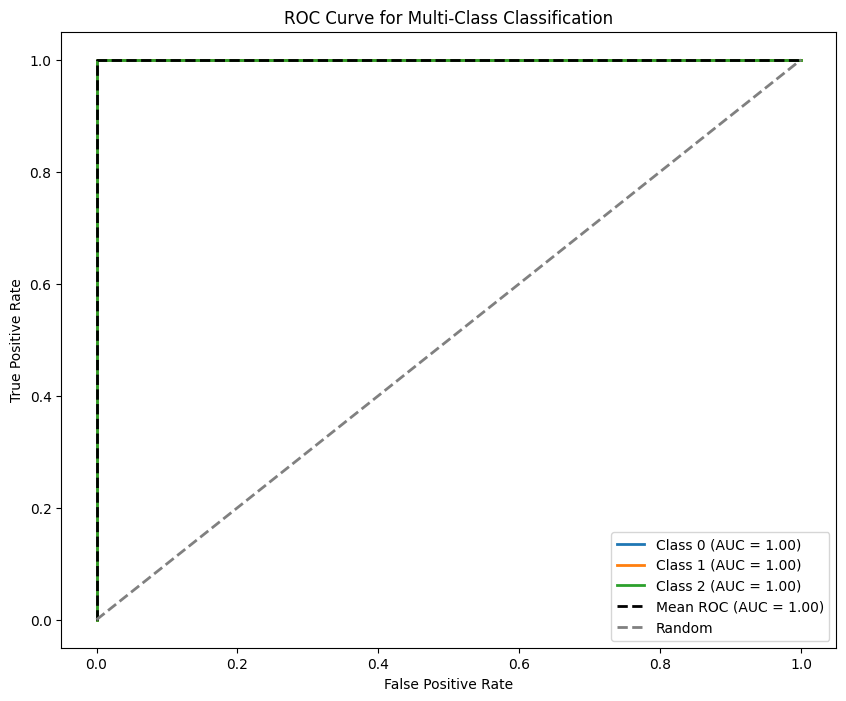

In [102]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np


# Initialize lists to store fpr, tpr, and roc_auc for each class
all_fpr = []
all_tpr = []
all_roc_auc = []

# Plot the ROC curve for each class
plt.figure(figsize=(10, 8))

for i in range(len(np.unique(y))):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_roc_auc.append(roc_auc)
    
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Calculate mean values
mean_fpr = np.mean(all_fpr, axis=0)
mean_tpr = np.mean(all_tpr, axis=0)
mean_roc_auc = np.mean(all_roc_auc)

# Plot the mean ROC curve
plt.plot(mean_fpr, mean_tpr, color='black', linestyle='--', lw=2, label=f'Mean ROC (AUC = {mean_roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2, label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc='lower right')
plt.show()


In [34]:
metrics.confusion_matrix(label_test, label_predict_test)
model.predict_proba(data_train)

array([[0.57142857, 0.42857143],
       [0.        , 1.        ],
       [1.        , 0.        ],
       ...,
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ]])

In [67]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a base Decision Tree classifier
base_classifier = linear_model.LogisticRegression()

# Create a OneVsRestClassifier with the base classifier
classifier = OneVsRestClassifier(base_classifier)

# Train the classifier
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score: {f1:.4f}")

# Calculate precision
precision = precision_score(y_test, y_pred, average='weighted')
print(f"Precision: {precision:.4f}")

# Calculate recall
recall = recall_score(y_test, y_pred, average='weighted')
print(f"Recall: {recall:.4f}")


Accuracy: 0.9667
F1 Score: 0.9664
Precision: 0.9694
Recall: 0.9667


In [50]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Load Iris dataset
iris = load_iris()
X = iris.data
y = label_binarize(iris.target, classes=[0, 1, 2])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a logistic regression classifier
classifier = OneVsRestClassifier(LogisticRegression(max_iter=1000))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# # Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(3):  # Three classes in Iris dataset
#     fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # Plot ROC curves
# plt.figure(figsize=(8, 6))

# colors = ['blue', 'red', 'green']
# for i, color in zip(range(3), colors):
#     plt.plot(fpr[i], tpr[i], color=color, lw=2,
#              label='ROC curve (class {0}) - AUC = {1:.2f}'.format(i, roc_auc[i]))

# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random Guessing')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve for Iris Dataset')
# plt.legend(loc='lower right')

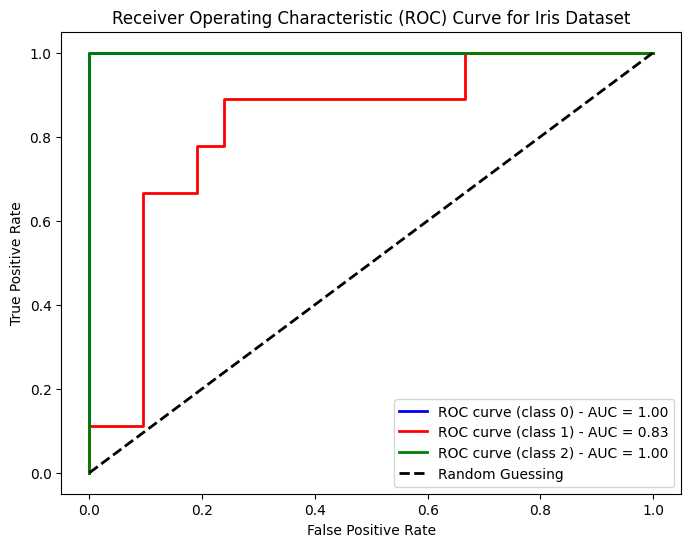

Trained Logistic Regression Model:
 LogisticRegression(max_iter=1000)


In [117]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Load Iris dataset
iris = load_iris()
X = iris.data
y = label_binarize(iris.target, classes=[0, 1, 2])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a logistic regression classifier
classifier = OneVsRestClassifier(LogisticRegression(max_iter=1000))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Store the trained logistic regression model
trained_logreg_model = classifier.estimators_[0]  # Assuming binary relevance for the first class

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):  # Three classes in Iris dataset
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))

colors = ['blue', 'red', 'green']
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve (class {0}) - AUC = {1:.2f}'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Iris Dataset')
plt.legend(loc='lower right')
plt.show()

# Output the trained logistic regression model
print("Trained Logistic Regression Model:\n", trained_logreg_model)


In [ ]:
for i in range(len(classes)):
      fpr[i], tpr[i], _ = metrics.roc_curve(label_test[:, i], label_predict_test[:, i])
      roc_auc[i] = metrics.auc(fpr[i], tpr[i])

In [301]:
from sklearn import metrics, model_selection
from Roc_Curve import Roc_curve
from Plot_Roc_Curve import Plot_Roc_curve
from sklearn import metrics


def output_network(x, labels, model, type_class, k_fold):
    if np.shape(x)[0] < np.shape(x)[1]:  # Convert Data training & Test >>>> m*n; m > n
        x = x.T
    # -------------------------------------------- K_fold ------------------------------------------
    cv = model_selection.StratifiedKFold(n_splits=k_fold)  # K-Fold
    # ------------------------------------------ ROC Parameters ------------------------------------
    i = 0
    tprs_tr, aucs_tr, tprs_te, aucs_te, accuracy_tr, accuracy_te = [], [], [], [], [], []

    mean_fpr = np.linspace(0, 1, 50)

    # ----------------------------------------- Training Network ------------------------------------
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey='row', figsize=(8, 5))
    fig.suptitle('Classification Type: ' + type_class, fontsize=12)
    for train, test in cv.split(x, labels):  # Train-test split
        data_train = x[train]  # Part Training
        label_train = labels[train]
        model.fit(data_train, label_train)  # Fit i.e., Training

        # ------------------------------------- Training Section ------------------------------------
        label_predict_train = model.predict(data_train)
        accuracy_train = model.score(data_train, label_train)
        cr_train = metrics.classification_report(label_train, label_predict_train, labels=np.unique(label_train))
        label_predict_train_prob = model.predict_proba(data_train)
        accuracy_tr.append(accuracy_train)
        # model.feature_importances_
        # -------------------------------------ROC for training -------------------------------------
        fpr_tr, tpr_tr, roc_auc_tr = Roc_curve(label_train, label_predict_train_prob)
        aucs_tr.append(roc_auc_tr)
        tprs_tr.append(np.interp(mean_fpr, fpr_tr, tpr_tr))
        tprs_tr[-1][0] = 0.0
        i += 1
        st = np.str(roc_auc_tr)
        ax1.plot(fpr_tr, tpr_tr, lw=1, alpha=0.4, label='ROC fold ' + np.str(i) + ' (AUC = ' + st[0:4] + ')')

        # ----------------------------------------- Test Section -------------------------------------
        data_test = x[test]
        label_test = labels[test]
        label_predict_test = model.predict(data_test)
        accuracy_test = model.score(data_test, label_test)
        cr_test = metrics.classification_report(label_test, label_predict_test, labels=np.unique(label_test))
        label_predict_test_prob = model.predict_proba(data_test)
        accuracy_te.append(accuracy_test)

        # -------------------------------------- ROC for test -----------------------------------------
        fpr_te, tpr_te, roc_auc_te = Roc_curve(label_test, label_predict_test_prob)
        aucs_te.append(roc_auc_te)
        tprs_te.append(np.interp(mean_fpr, fpr_te, tpr_te))
        tprs_te[-1][0] = 0.0
        st = np.str(roc_auc_te)
        ax2.plot(fpr_te, tpr_te, lw=1, alpha=0.4, label='ROC fold ' + np.str(i) + ' (AUC = ' + st[0:4] + ')')

    ax1.set_ylabel("True Positive Rate")
    Plot_Roc_curve(tprs_tr, mean_fpr, aucs_tr, ax1, title='Training')
    Plot_Roc_curve(tprs_te, mean_fpr, aucs_te, ax2, title='Test')
    plt.show()
    plot_classifier(data_train, label_train, data_test, label_test, label_predict_train, label_predict_test, k_fold, model, type_class)
    return np.mean(accuracy_tr), cr_train, np.mean(accuracy_te), cr_test


In [ ]:
output_network(x, labels, model, type_class, k_fold)

In [ ]:
Accuracy_Train, Cr_Train, Accuracy_Test, Cr_Test = output_network(data, labels, model, type_class, k_fold=5)

In [ ]:

from sklearn import datasets
from Filtering import filtering
from Clustering import clustering
from Preparing_data import preparing_data
from Normalize import normalize_data
from Classification import classification
from Plot_clustering import plot_cluster
from Feature_Selection import featureselection
from Feature_Extraction import feature_extraction
from Output_Training_Test_Network import output_network


# ======================================= Step 3: Feature Extraction & Selection =======================================
# Data = feature_extraction(Data, Labels, number_feature=3, number_neighbors=70, type_feature='LDA')
# Data = featureselection(Data, Labels, threshold=0.1, number_feature=3, c_l1fs=0.01, n_estimators_tfs=100,  type_feature='MI')
"""
Feature Extraction:
PCA:Principal Component Analysis; LDA:Linear discriminant analysis; ICA: Independent component analysis; SVD: Singular value decomposition
TSNE:T-distributed stochastic neighbor embedding; FA: Factor analysis; Isomap: Isometric Feature Mapping
Feature Selection:
Variance; Mutual information (MI); Chi-square test (Chi-square); fisher_score (FS); Forward feature selection (FFS);
Backward feature selection (BFS); Exhaustive Feature Selection (EFS); Recursive feature elimination (RFE); Random Forest (RF)
Univariate feature selection (UFS); L1-based feature selection (L1FS), Tree-based feature selection (TFS)
"""
# ===================================== Step 4: Classification & Clustering ==========================================
# ----------------------------------------- Step 4: Classification ---------------------------------------------------

Accuracy_Train, Cr_Train, Accuracy_Test, Cr_Test = output_network(Data, Labels, model, type_class, k_fold=5)
"""
type_class: 'KNN', 'LR', 'MLP', 'SVM', 'DT', 'NB', 'RF', 'AdaBoost', 'XGBoost', 'LDA'

LR: LogisticRegression; MLP: Multilayer perceptron, SVM:Support Vector Machine; DT: Decision Tree; NB: Naive Bayes;
RF: Random Forest; AdaBoost; XGBoost; LDA: Linear Discriminant Analysis; KNN:K-Nearest Neighbors 
Parameters:
The number of hidden layers: hidden_layer_mlp; The number of epochs MLP: max_iter,

max_depth=The maximum depth of the tree, random forest and XGBoost;;
n_estimators:The number of trees in the forest.
"""
# ----------------------------------------- Step 4: Clustering -----------------------------------------------------
clustering(Data, n_clusters=3, max_iter=100, thr_brich=0.5,  branchfactor_brich=50, n_neighbor_SpecCluster=10,
           minsamples_optics=15, max_dist_optics=5, batch_size_MBKmeans=10, type_cluster='MiniBatchKMeans')
"""
type_cluster: kmeans; Agglomerative; DBSCAN; GMM:Gaussian Mixture Models; Meanshift; Birch; SpectralClustering; 
OPTICS; MiniBatchKMeans
"""


In [ ]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=50, centers=2, random_state=0, cluster_std=0.8)

In [ ]:
from scipy import stats
mpg = [21.0, 21.0, 22.8, 21.4, 18.7, 18.1, 14.3, 24.4, 22.8, 19.2, 17.8, 16.4, 17.3, 15.2, 10.4, 10.4, 14.7, 32.4, 30.4,
       33.9, 21.5, 15.5, 15.2, 13.3, 19.2, 27.3, 26.0, 30.4, 15.8,19.7, 15.0, 21.4]

hp = [110, 110, 93, 110, 175, 105, 245, 62, 95, 123, 123, 180,180, 180, 205, 215, 230, 66, 52, 65, 97, 150, 150, 245,
     175, 66, 91, 113, 264, 175, 335, 109]

stats.pearsonr(mpg, hp)

stats.spearmanr(mpg,hp)
stats.spearmanr(mpg,hp)

In [ ]:
if len(y.shape) > 1:
        labels = np.max(labels) + 1  # Assuming classes are 0-indexed
    
    num_classes = np.max(labels) + 1  
    labels = np.eye(num_classes)[labels]    